# Task 2

---

## Predictive modeling of customer bookings


### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from  sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### testing varies model to find the optimum one

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

# initial data exposoition

##setting columns and other basic statistics and spliting of dataset


In [8]:
categorical=['sales_channel','trip_type','route','booking_origin']
numerical=['num_passengers','purchase_lead','length_of_stay','flight_hour','flight_duration']
numerised_categoricals=['flight_day','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals','booking_complete']

In [9]:
print("information")
print(df.info())



information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory 

In [10]:
print(" statistical information of the dataset")
print(df.describe())
complete=df[df['booking_complete']==0]
booking_not_complete=df[df['booking_complete']==0]

 statistical information of the dataset
       num_passengers  purchase_lead  length_of_stay  flight_hour    flight_day  wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  flight_duration  booking_complete
count    50000.000000   50000.000000     50000.00000  50000.00000  50000.000000         50000.000000          50000.000000           50000.000000     50000.000000      50000.000000
mean         1.591240      84.940480        23.04456      9.06634      3.814420             0.668780              0.296960               0.427140         7.277561          0.149560
std          1.020165      90.451378        33.88767      5.41266      1.992792             0.470657              0.456923               0.494668         1.496863          0.356643
min          1.000000       0.000000         0.00000      0.00000      1.000000             0.000000              0.000000               0.000000         4.670000          0.000000
25%          1.000000      21.000000         5.00000   

<Axes: ylabel='count'>

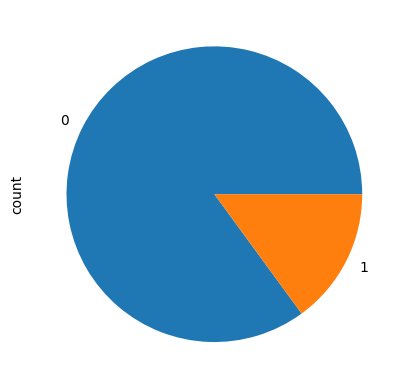

In [11]:
df['booking_complete'].value_counts().plot(kind='pie')

In [12]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Sample data: scores by department
# data = {
#     'Department': ['Sales', 'HR', 'Tech'],
#     'Score > 50': [8, 5, 12],
#     'Score ≤ 50': [2, 3, 4]
# }
# df = pd.DataFrame(data)
# # Set position for each bar
# x = df['Department']

# # Plot stacked bars
# plt.bar(x, df['Score > 50'], label='Score > 50', color='green')
# plt.bar(x, df['Score ≤ 50'], bottom=df['Score > 50'], label='Score ≤ 50', color='red')

# # Add labels and legend
# plt.title('Stacked Bar Chart: Score Distribution by Department')
# plt.ylabel('Number of People')
# plt.legend()
# plt.show()

In [13]:
(df['sales_channel']=='Mobile').value_counts()

sales_channel
False    44382
True      5618
Name: count, dtype: int64

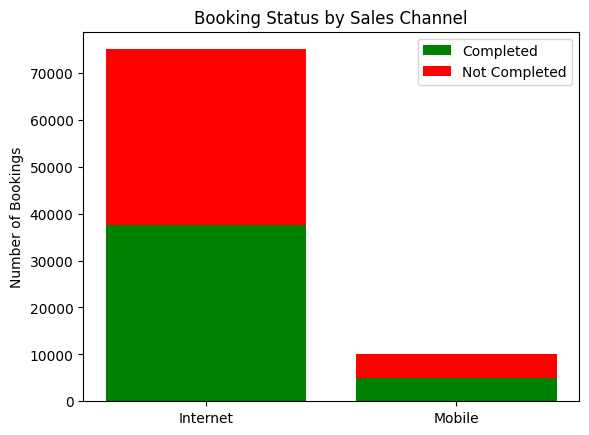

In [ ]:
import matplotlib.pyplot as plt


completed_counts = complete['sales_channel'].value_counts()


not_completed_counts = booking_not_complete['sales_channel'].value_counts()


labels = ['Internet', 'Mobile']
completed = [completed_counts.get(label, 0) for label in labels]
not_completed = [not_completed_counts.get(label, 0) for label in labels]

# Plot stacked bar chart
x = range(len(labels))
plt.bar(x, completed, label='Completed', color='green')
plt.bar(x, not_completed, bottom=completed, label='Not Completed', color='red')

# Labeling
plt.xticks(x, labels)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by Sales Channel')
plt.legend()
plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9')])

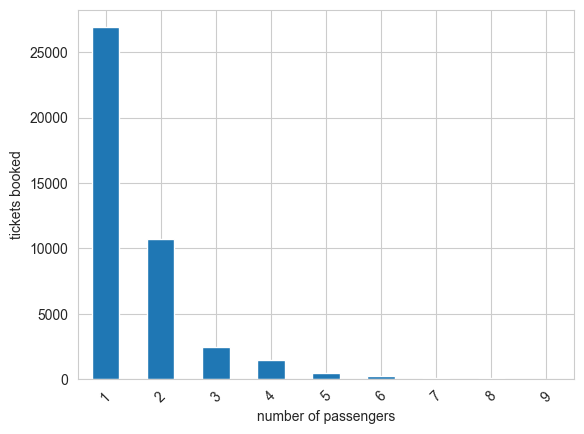

In [20]:
complete['num_passengers'].value_counts().plot(kind="bar")
sns.set_style('whitegrid')
plt.xlabel("number of passengers")
plt.ylabel("tickets booked")
plt.xticks(rotation=45)

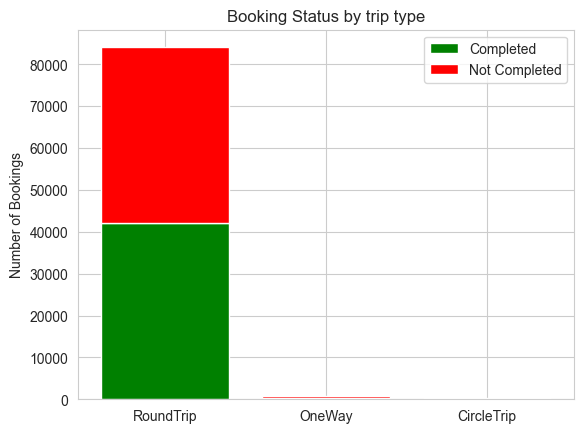

In [24]:
completed_counts=complete['trip_type'].value_counts()
not_booked_counts=booking_not_complete['trip_type'].value_counts()
labels=['RoundTrip','OneWay','CircleTrip']
completed=[completed_counts.get(label,0) for label in  labels]
not_booked=[not_booked_counts.get(label,0) for label in  labels]
x = range(len(labels))
plt.bar(x, completed, label='Completed', color='green')
plt.bar(x, not_booked, bottom=completed, label='Not Completed', color='red')

# Labeling
plt.xticks(x, labels)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by trip type')
plt.legend()
plt.show()

In [15]:
from sklearn.preprocessing import OneHotEncoder

df['sales_channel_1']=OneHotEncoder().fit_transform(df['sales_channel'].copy())

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

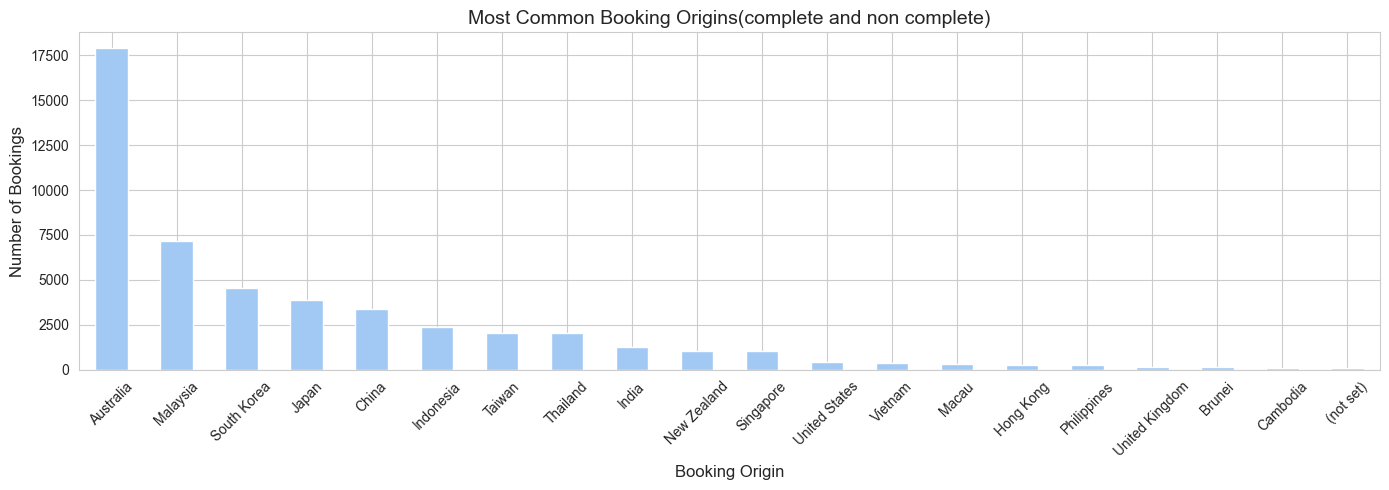

In [ ]:


booking_complete = df['booking_origin'].value_counts()


sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(14, 5))
booking_complete.head(20).plot(kind='bar')

plt.title('Most Common Booking Origins(complete and non complete)', fontsize=14)
plt.xlabel('Booking Origin', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

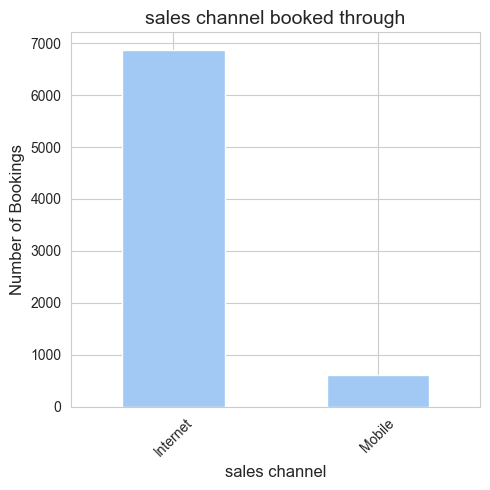

In [ ]:


booking_complete = df[df['booking_complete'] == 1]
sales_channel_booked = booking_complete['sales_channel'].value_counts()

sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(5, 5))
sales_channel_booked.head(20).plot(kind='bar')

plt.title('sales channel booked through', fontsize=14)
plt.xlabel('sales channel', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

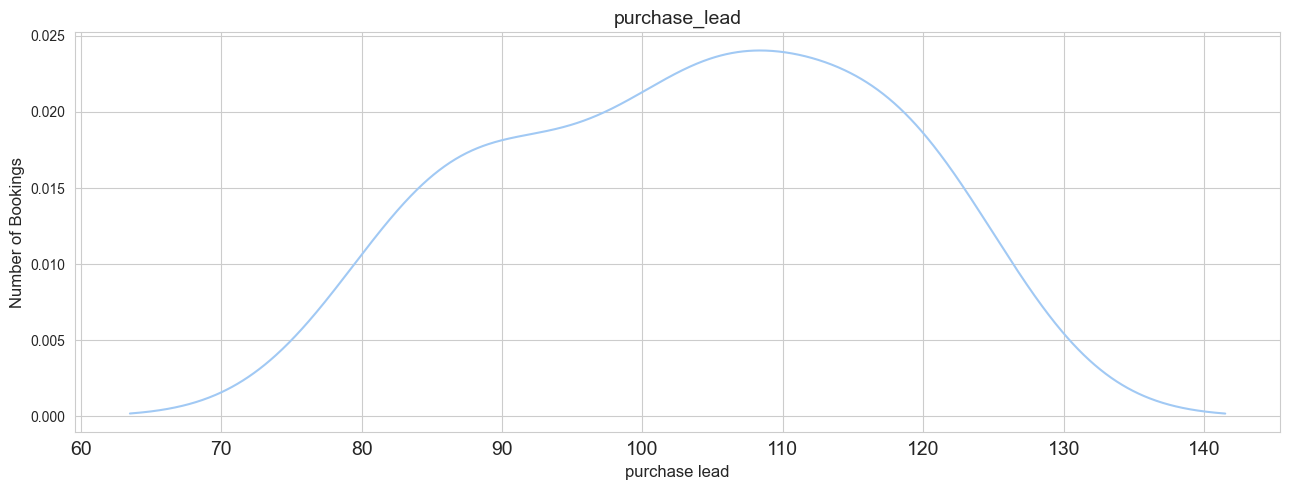

In [ ]:

booking_complete = df[df['booking_complete'] == 1]
purchase_lead = booking_complete['purchase_lead'].value_counts()

sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(13, 5))
purchase_lead.head(20).plot(kind='kde')
plt.xticks(fontsize=14)
plt.title('purchase_lead', fontsize=14)
plt.xlabel("purchase lead", fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)

plt.tight_layout()
plt.show()

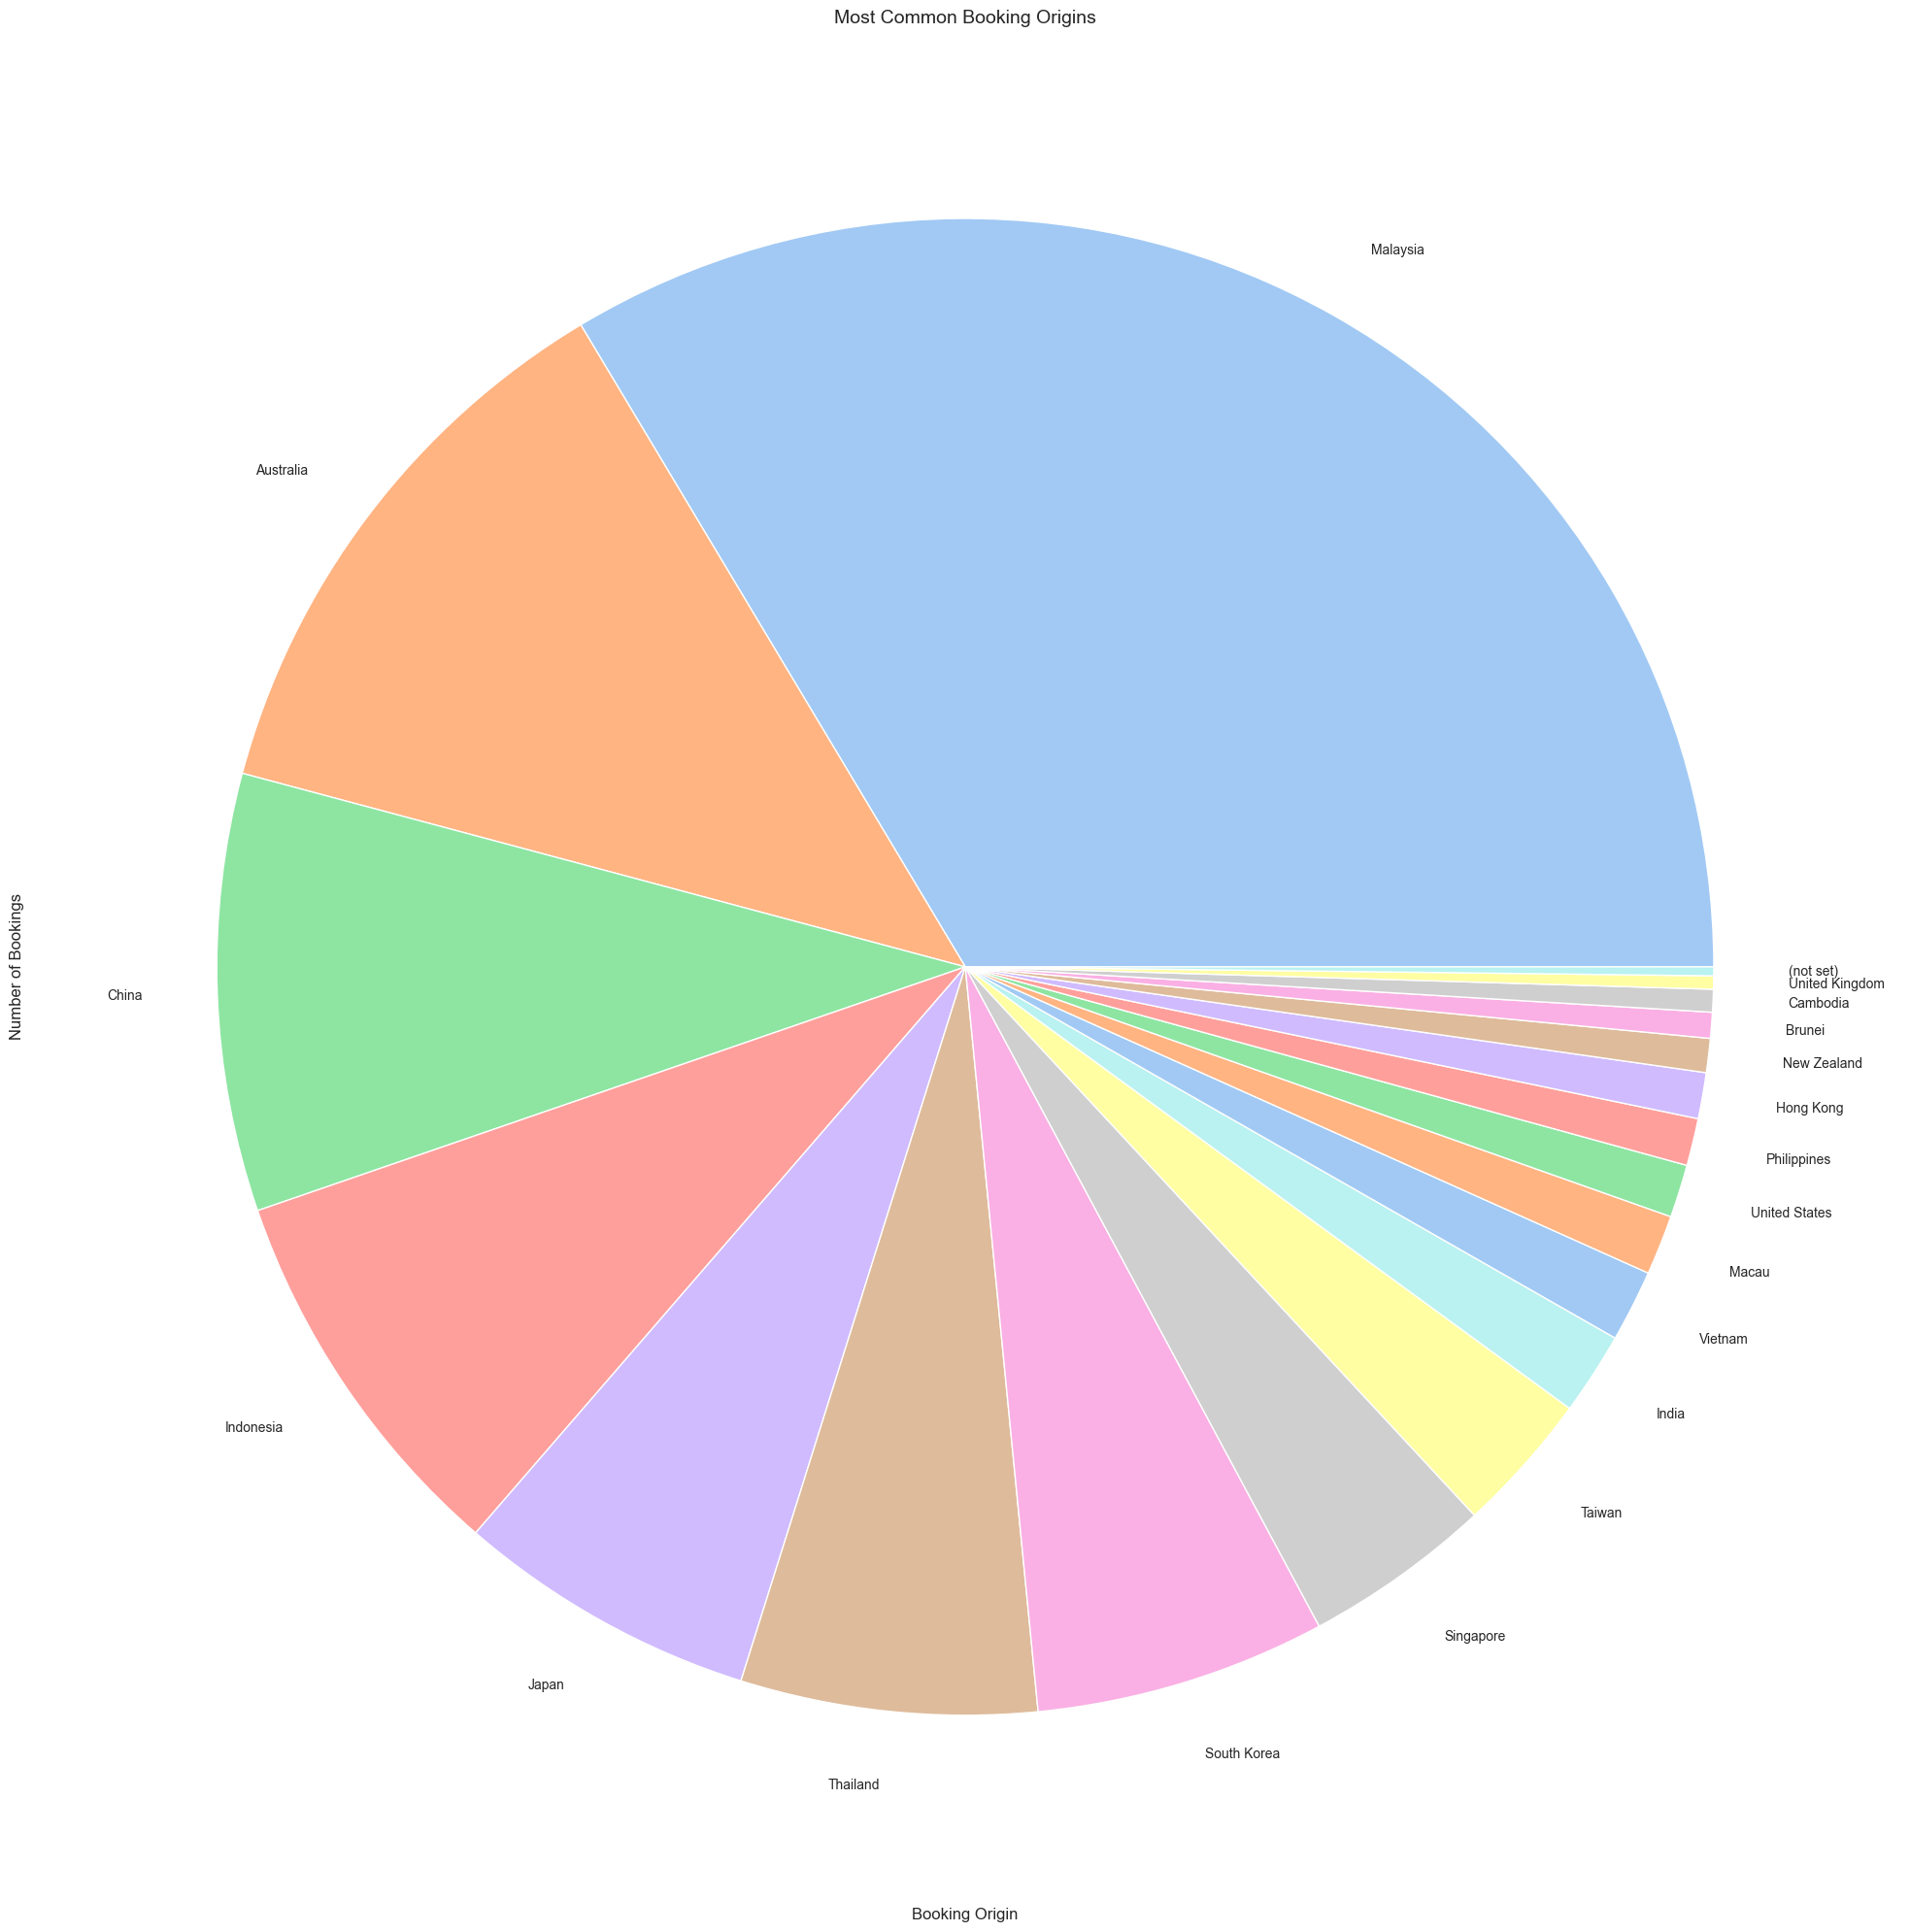

In [ ]:

booking_complete = df[df['booking_complete'] == 1]
most_booking_done = booking_complete['booking_origin'].value_counts()

sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(20, 20))
most_booking_done.head(20).plot(kind='pie')
plt.xticks(fontsize=40)
plt.title('Most Common Booking Origins', fontsize=14)
plt.xlabel('Booking Origin', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)

plt.tight_layout()
plt.show()

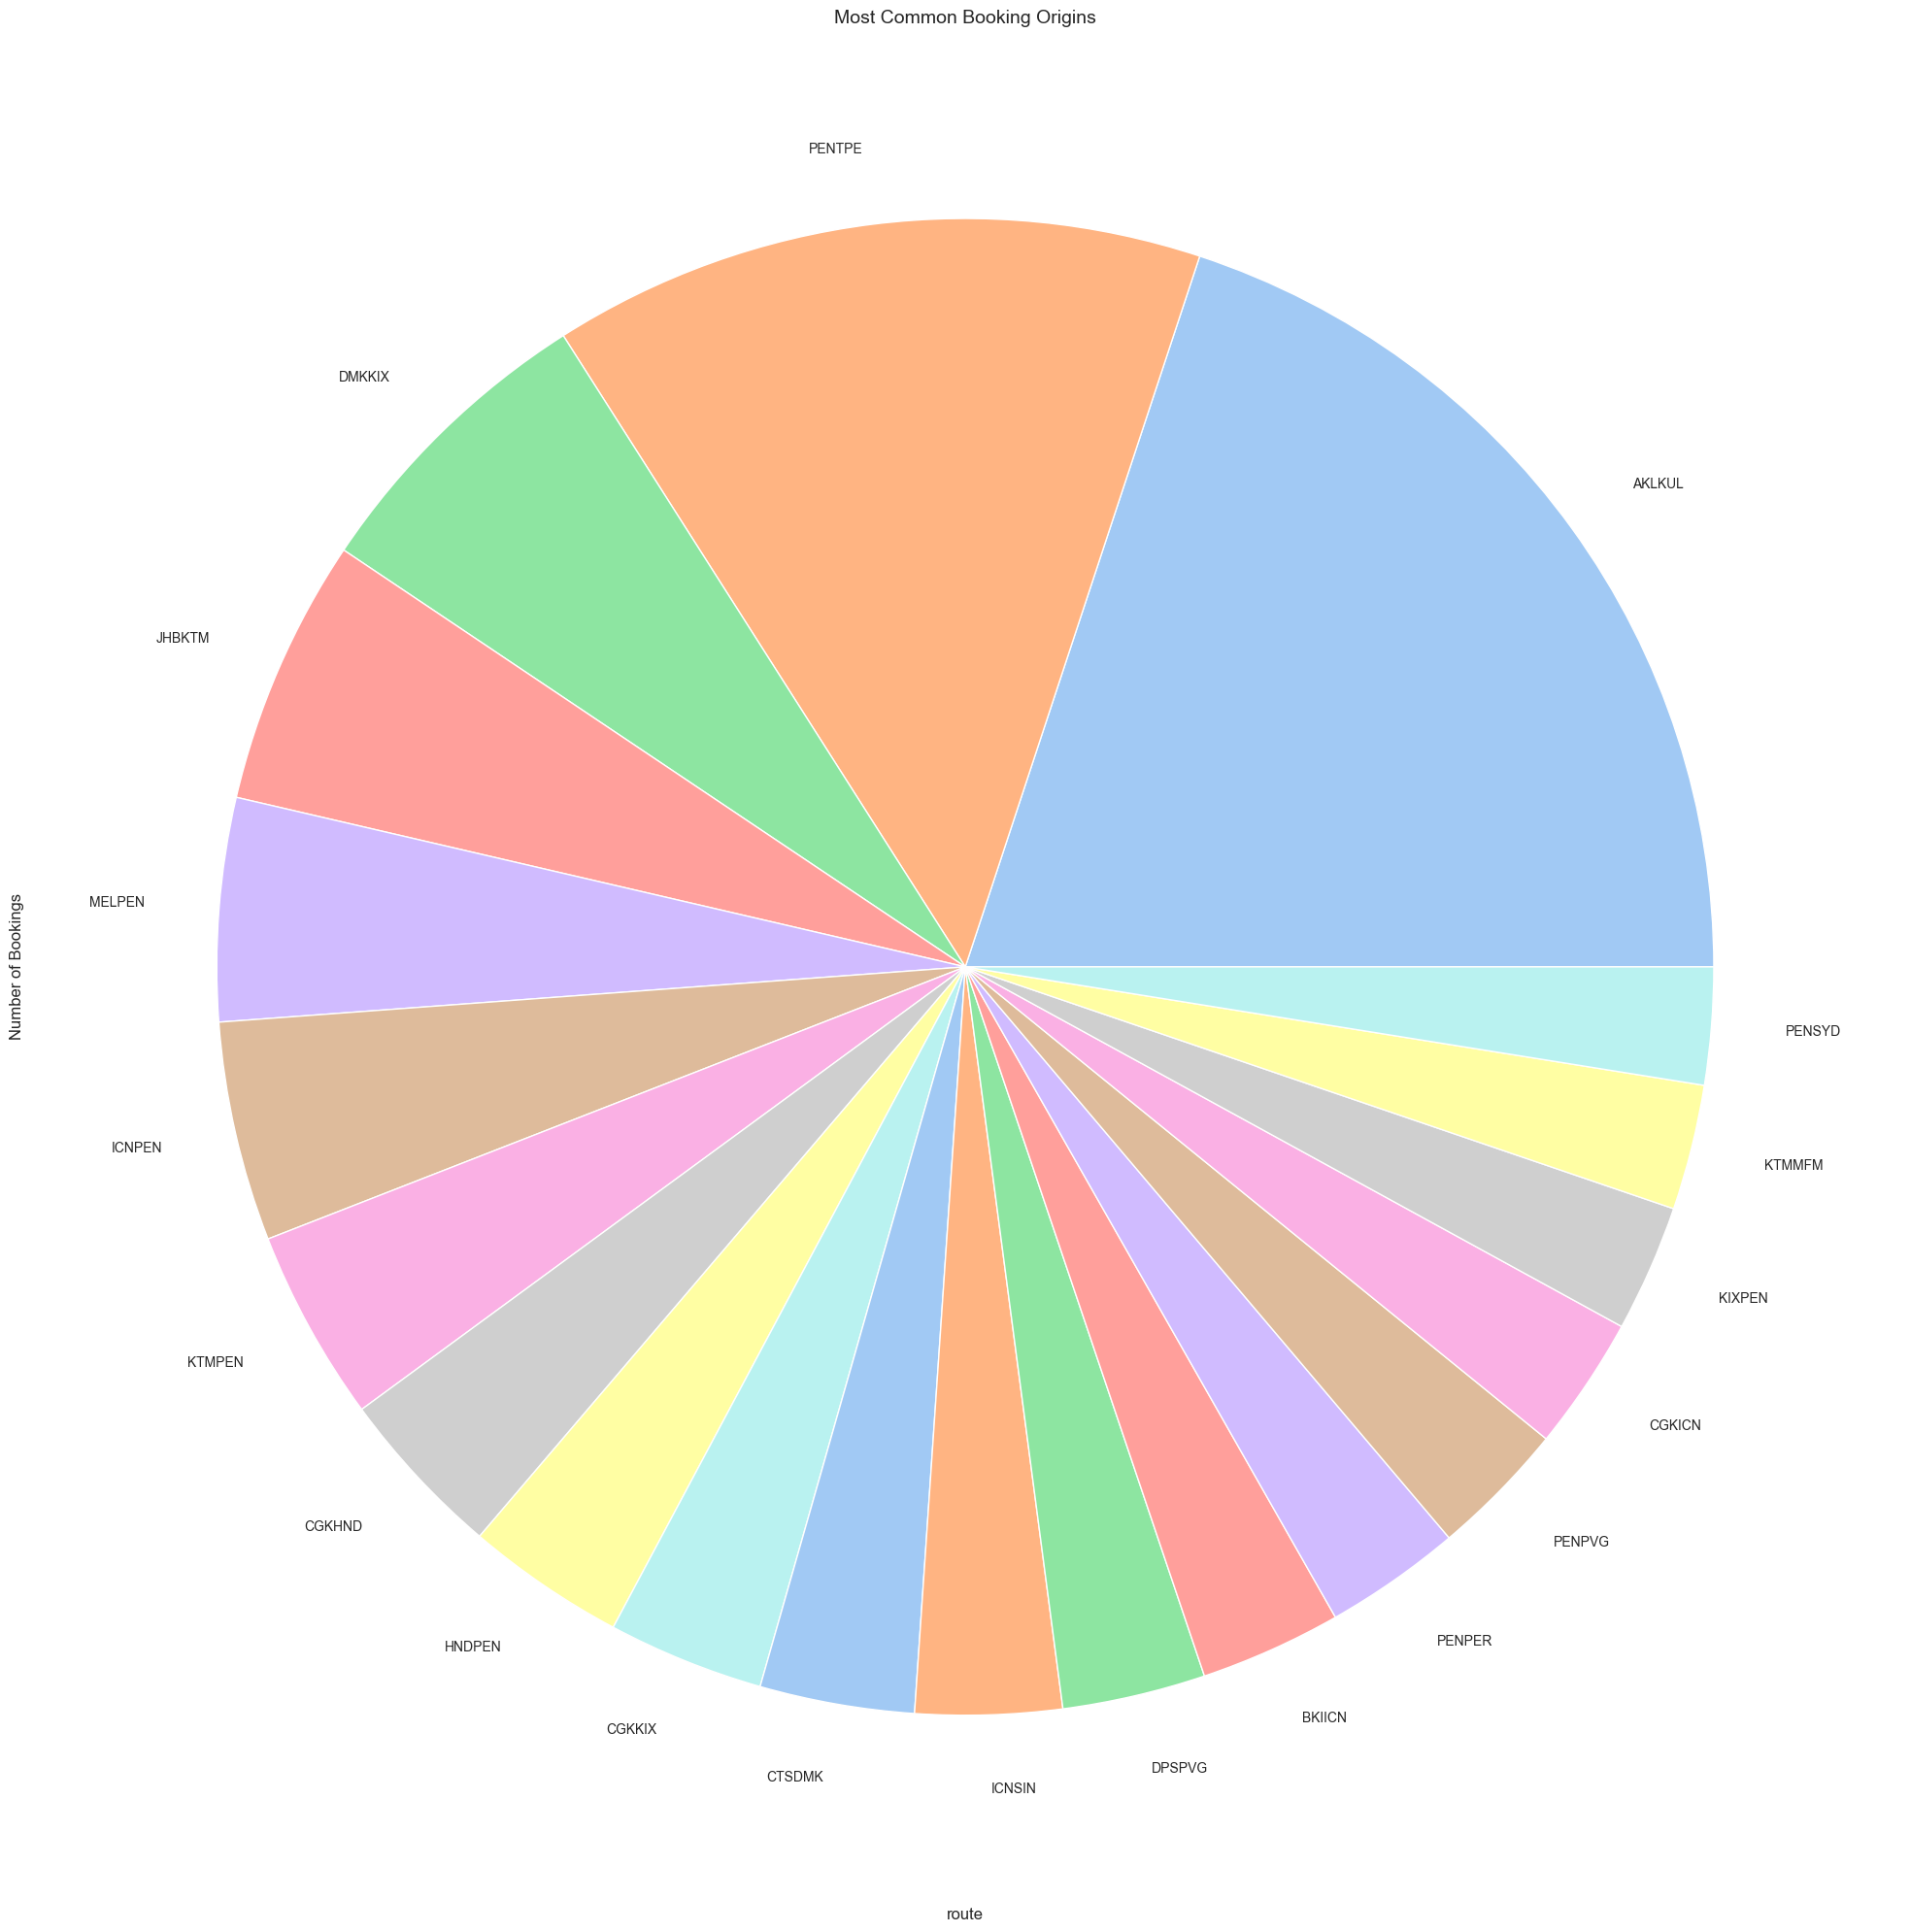

In [ ]:

booking_complete = df[df['booking_complete'] == 1]
most_booking_done = booking_complete["route"].value_counts()

sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(20, 20))
most_booking_done.head(20).plot(kind='pie')
plt.xticks(fontsize=40)
plt.title('Most Common Booking Origins', fontsize=14)
plt.xlabel('route', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
most_length_of_stay=booking_complete["length_of_stay"].value_counts()
plt.figure(14,5)
most_length_of_stay.head(20).plot(kind="bar")
plt.xticks(rotation="45")
plt.xlabel("length of stay")
plt.ylabel("booking ")
plt.show()

TypeError: Value after * must be an iterable, not int

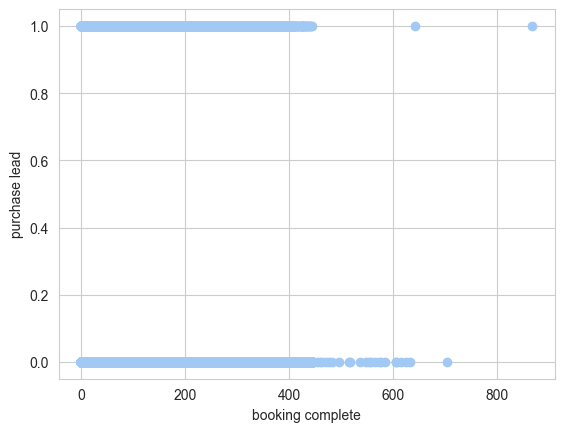

In [ ]:
plt.scatter(df['purchase_lead'],df['booking_complete'])
plt.xlabel("booking complete")
plt.ylabel("purchase lead")
plt.show()

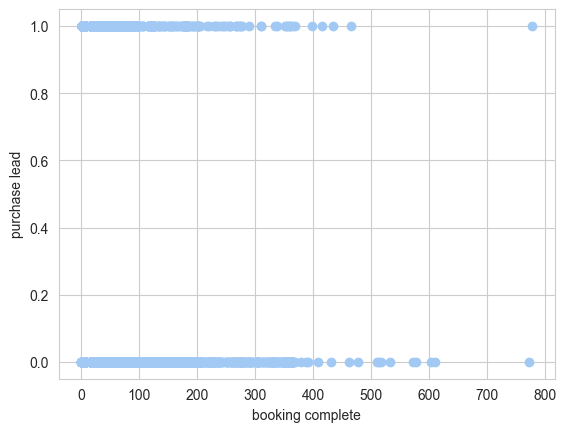

In [ ]:
plt.scatter(df['length_of_stay'],df['booking_complete'])
plt.xlabel("booking complete")
plt.ylabel("purchase lead")
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
column=['purchase_lead  ']

OneHotEncoder.fit_transform(column)

corr_matrix = df[column].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

TypeError: TransformerMixin.fit_transform() missing 1 required positional argument: 'X'